<a href="https://colab.research.google.com/github/sbooeshaghi/azucar/blob/main/analysis/livecell/livecell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet leidenalg louvain anndata umap-learn pynndescent session-info
!pip install --quiet --no-deps scanpy

     |████████████████████████████████| 1.3 MB 3.8 MB/s 
     |████████████████████████████████| 1.1 MB 20.7 MB/s 
     |████████████████████████████████| 96 kB 2.5 MB/s 
     |████████████████████████████████| 88 kB 2.2 MB/s 
     |████████████████████████████████| 1.1 MB 33.8 MB/s 
     |████████████████████████████████| 3.2 MB 44.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 2.0 MB 5.1 MB/s 


In [2]:
!curl -Ls https://github.com/sbooeshaghi/azucar/blob/main/data/livecell/rep1/rep.h5ad.gz?raw=true | gunzip > rep1.h5ad
!curl -Ls https://github.com/sbooeshaghi/azucar/blob/main/data/livecell/rep2/rep.h5ad.gz?raw=true | gunzip > rep2.h5ad

In [20]:
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize, scale
import glob

import numpy.lib.recfunctions as rf

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, color="lightgray",linestyle="--", zorder=0)
  ax.set_aspect('equal')
  ax.set(**{
      "aspect": "equal",
      "xlim": lims,
      "ylim": lims
  })
  return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [4]:
r1 = anndata.read_h5ad("rep1.h5ad")
r1.layers["raw"] = r1.X
r1.var.index = r1.var["gene_name"].astype(str) + "_" + r1.var.index.astype(str)

r2 = anndata.read_h5ad("rep2.h5ad")
r2.layers["raw"] = r2.X
r2.var.index = r2.var["gene_name"].astype(str) + "_" + r2.var.index.astype(str)

In [5]:
print(f"Replicate 1: {r1.shape}")
print(f"Replicate 2: {r2.shape}")

Replicate 1: (5817, 116080)
Replicate 2: (4377, 116080)


# QC

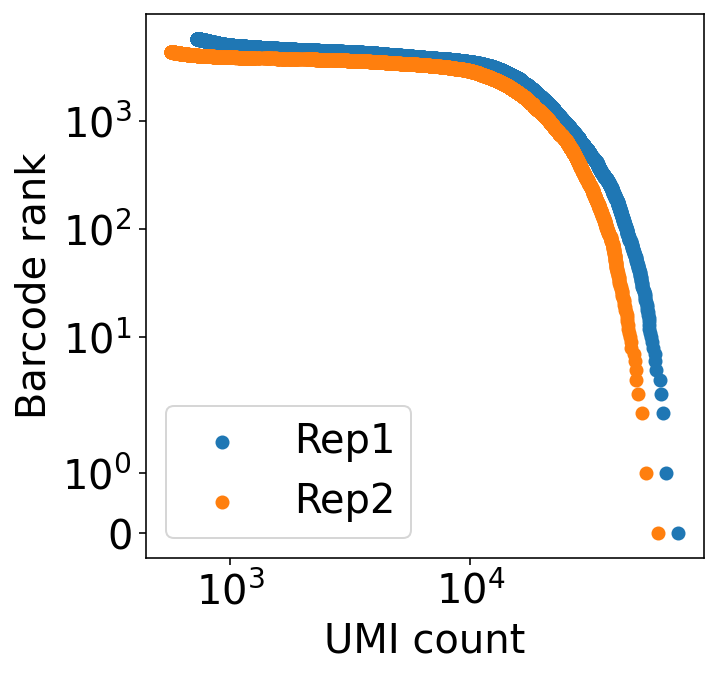

In [137]:
fig, ax = plt.subplots(figsize=(5,5))

data = r1
label = "Rep1"
x = np.sort(nd(data.X.sum(1)))[::-1]
y = np.arange(data.shape[0])

ax.scatter(x,y, label=label)

data = r2
label = "Rep2"
x = np.sort(nd(data.X.sum(1)))[::-1]
y = np.arange(data.shape[0])

ax.scatter(x,y, label=label)

ax.set(**{
    "xlabel": "UMI count",
    "ylabel": "Barcode rank",
    "xscale": "symlog",
    "yscale": "symlog"
})

ax.legend()

fig.show()

In [132]:
# Simple assignment

markers = {
    "hg": ["mtag1", "mtag2"], 
    "mm": ["mtag3", "mtag4"]
}

markers_idx = {
    0: "hg", 
    1: "mm"
}

markers_idx_r2 = {
    0: "mm", 
    1: "hg"
}

# Assigning based on gene expression
r1.obs["hg_counts"] = nd(r1[:,r1.var.index.str.contains("_ENSG")].X.sum(1))
r1.obs["mm_counts"] = nd(r1[:,r1.var.index.str.contains("_ENSMUS")].X.sum(1))

r2.obs["hg_counts"] = nd(r2[:,r2.var.index.str.contains("_ENSG")].X.sum(1))
r2.obs["mm_counts"] = nd(r2[:,r2.var.index.str.contains("_ENSMUS")].X.sum(1))

r1.obs["exp_origin"] = pd.Series(np.argsort(r1.obs[["hg_counts", "mm_counts"]].values)[:,1]).map(markers_idx).values
r2.obs["exp_origin"] = pd.Series(np.argsort(r2.obs[["hg_counts", "mm_counts"]].values)[:,1]).map(markers_idx).values

# Assigning based on mtags
r1.obs["tag12"] = r1.obs["mtag1"] + r1.obs["mtag2"]
r1.obs["tag34"] = r1.obs["mtag3"] + r1.obs["mtag4"]

r2.obs["tag12"] = r2.obs["mtag1"] + r2.obs["mtag2"]
r2.obs["tag34"] = r2.obs["mtag3"] + r2.obs["mtag4"]

r1.obs["tag_origin"] = pd.Series(np.argsort(r1.obs[["tag12", "tag34"]].values)[:,1]).map(markers_idx).values
r2.obs["tag_origin"] = pd.Series(np.argsort(r2.obs[["tag12", "tag34"]].values)[:,1]).map(markers_idx_r2).values

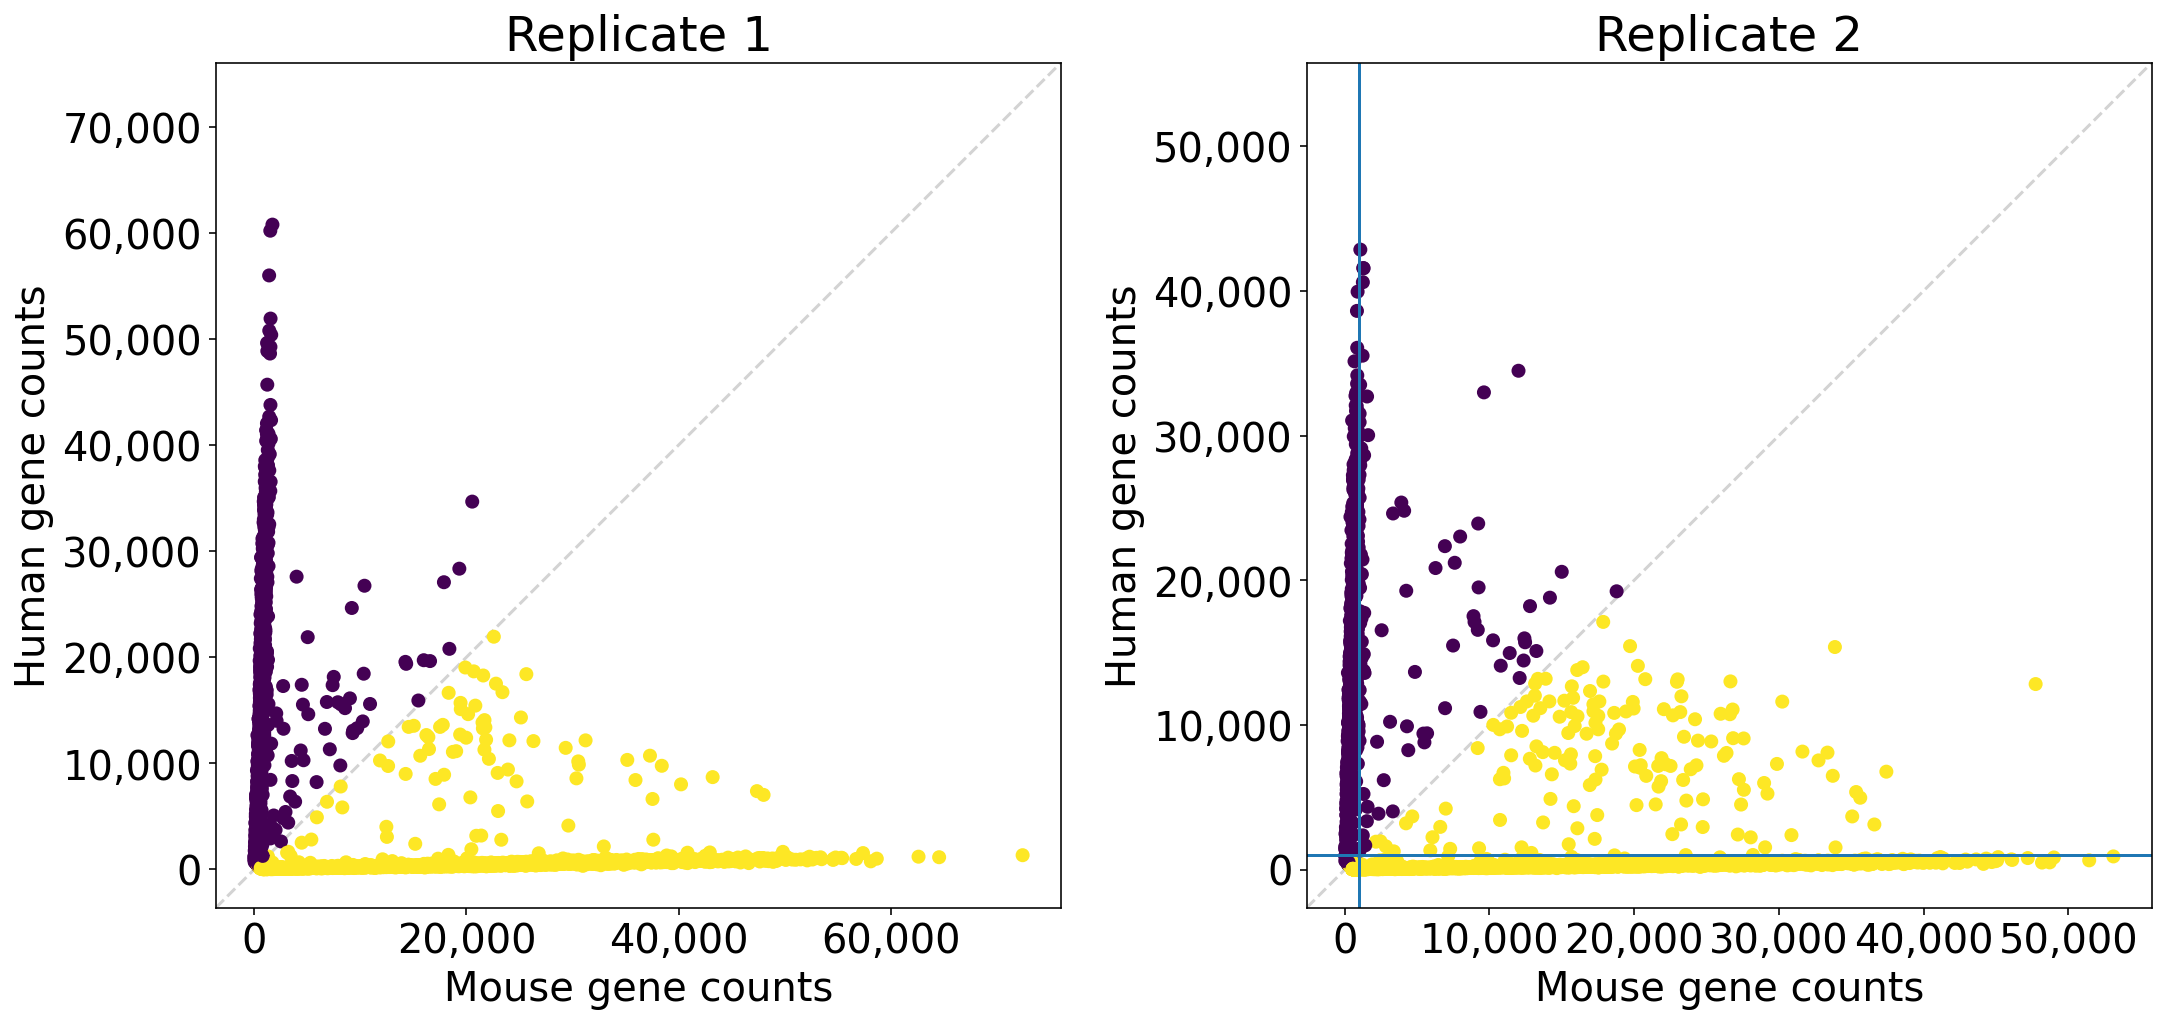

In [68]:
fig, axs = plt.subplots(figsize=(15,7), ncols=2, constrained_layout=True)

ax = axs[0]
x = r1.obs["mm_counts"]
y = r1.obs["hg_counts"]
c = r1.obs["exp_origin"].astype("category").cat.codes
ax.scatter(x,y, c=c)

ax.set(**{
    "title": "Replicate 1",
    "xlabel": "Mouse gene counts",
    "ylabel": "Human gene counts",
})
yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax = axs[1]
x = r2.obs["mm_counts"]
y = r2.obs["hg_counts"]
c = r2.obs["exp_origin"].astype("category").cat.codes
ax.scatter(x,y, c=c)

ax.set(**{
    "title": "Replicate 2",
    "xlabel": "Mouse gene counts",
    "ylabel": "Human gene counts",
})
yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.axhline(y=1000)
ax.axvline(x=1000)
fig.show()

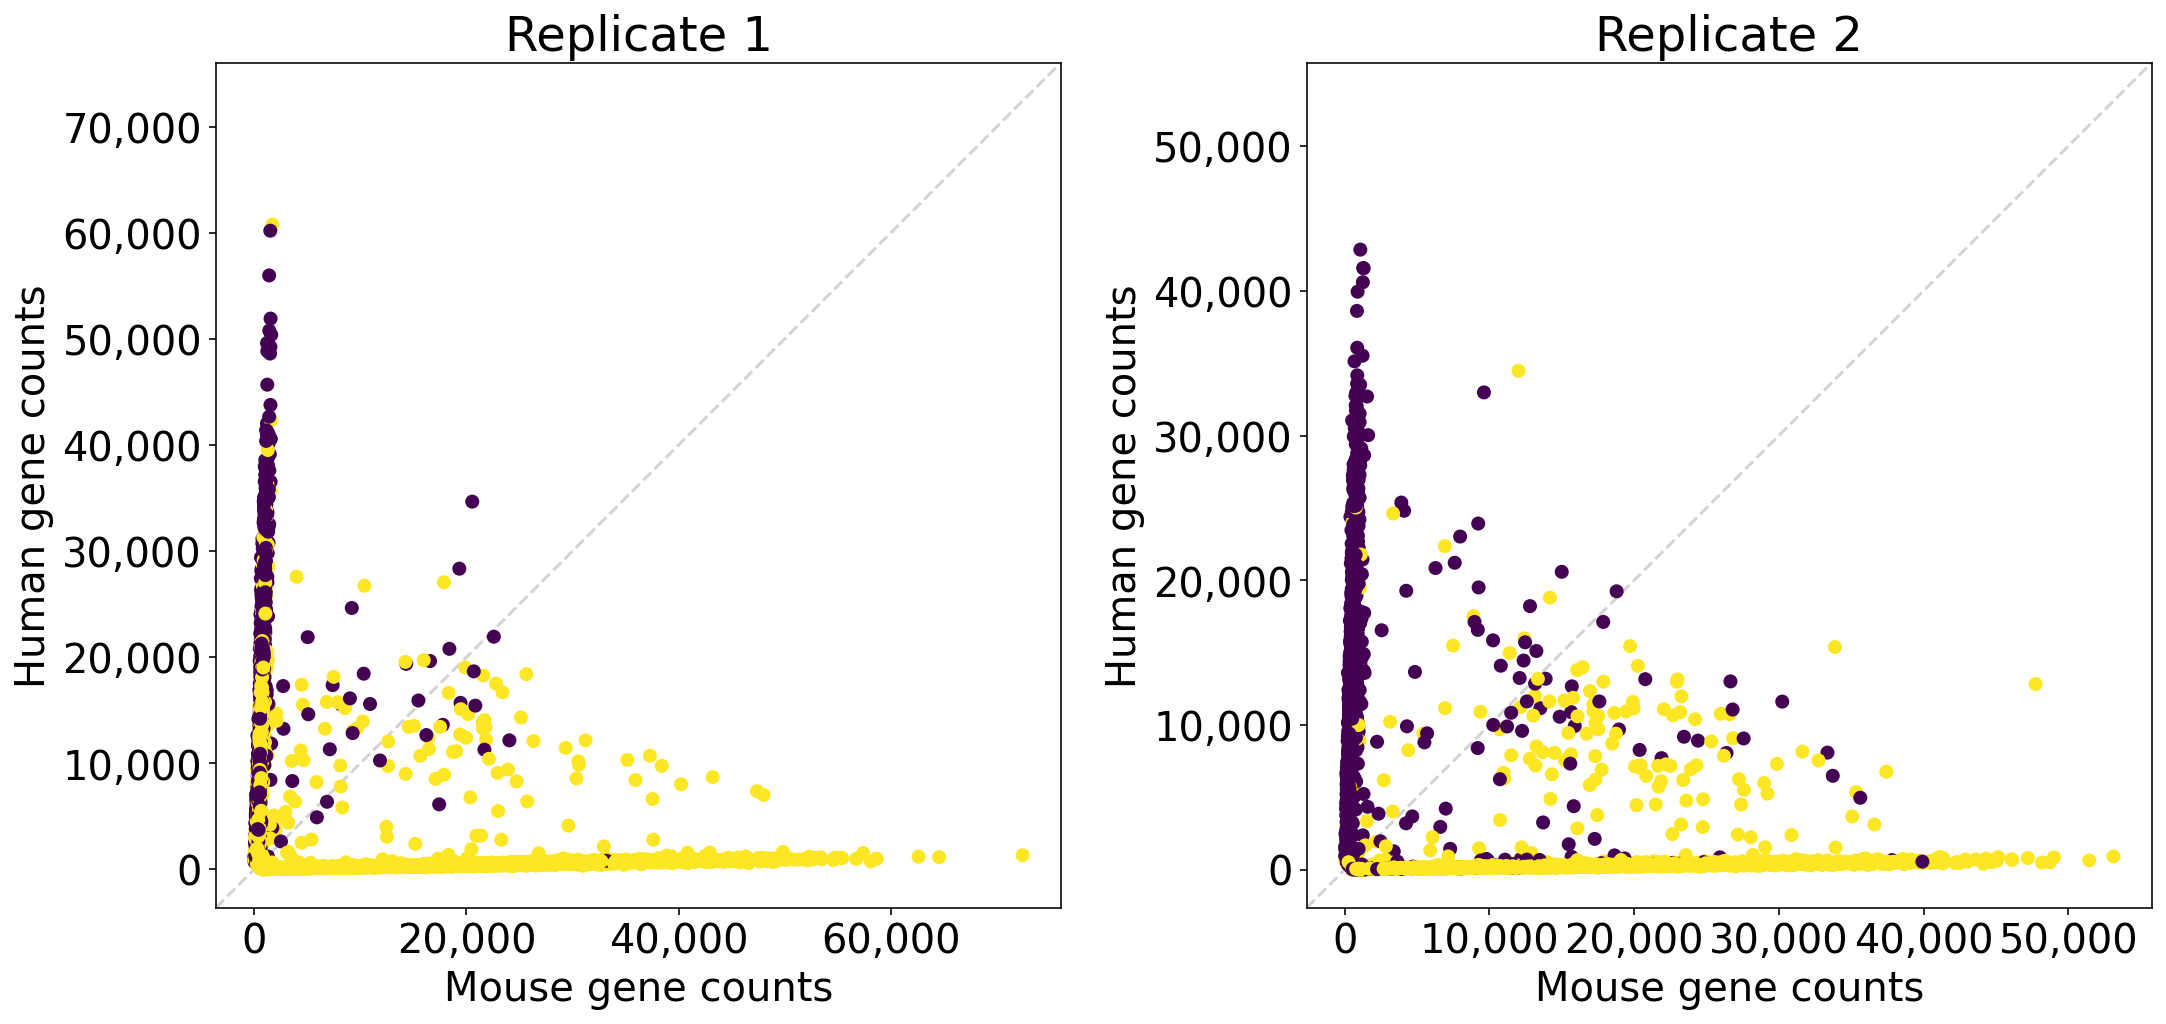

In [133]:
fig, axs = plt.subplots(figsize=(15,7), ncols=2, constrained_layout=True)

ax = axs[0]
x = r1.obs["mm_counts"]
y = r1.obs["hg_counts"]
c = r1.obs["tag_origin"].astype("category").cat.codes
ax.scatter(x,y, c=c)

ax.set(**{
    "title": "Replicate 1",
    "xlabel": "Mouse gene counts",
    "ylabel": "Human gene counts",
})
yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

ax = axs[1]
x = r2.obs["mm_counts"]
y = r2.obs["hg_counts"]
c = r2.obs["tag_origin"].astype("category").cat.codes
ax.scatter(x,y, c=c)

ax.set(**{
    "title": "Replicate 2",
    "xlabel": "Mouse gene counts",
    "ylabel": "Human gene counts",
})
yex(ax)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

fig.show()

In [134]:
mask1 = np.logical_xor(r1.obs["hg_counts"] > 1000, r1.obs["mm_counts"] > 1000)
mask2 = np.logical_xor(r2.obs["hg_counts"] > 1000, r2.obs["mm_counts"] > 1000)

In [63]:
from sklearn.metrics import confusion_matrix

In [135]:
cfm1 = confusion_matrix(r1.obs["exp_origin"][mask1], r1.obs["tag_origin"][mask1], labels=["hg", "mm"])
cfm2 = confusion_matrix(r2.obs["exp_origin"][mask2], r2.obs["tag_origin"][mask2], labels=["hg", "mm"])

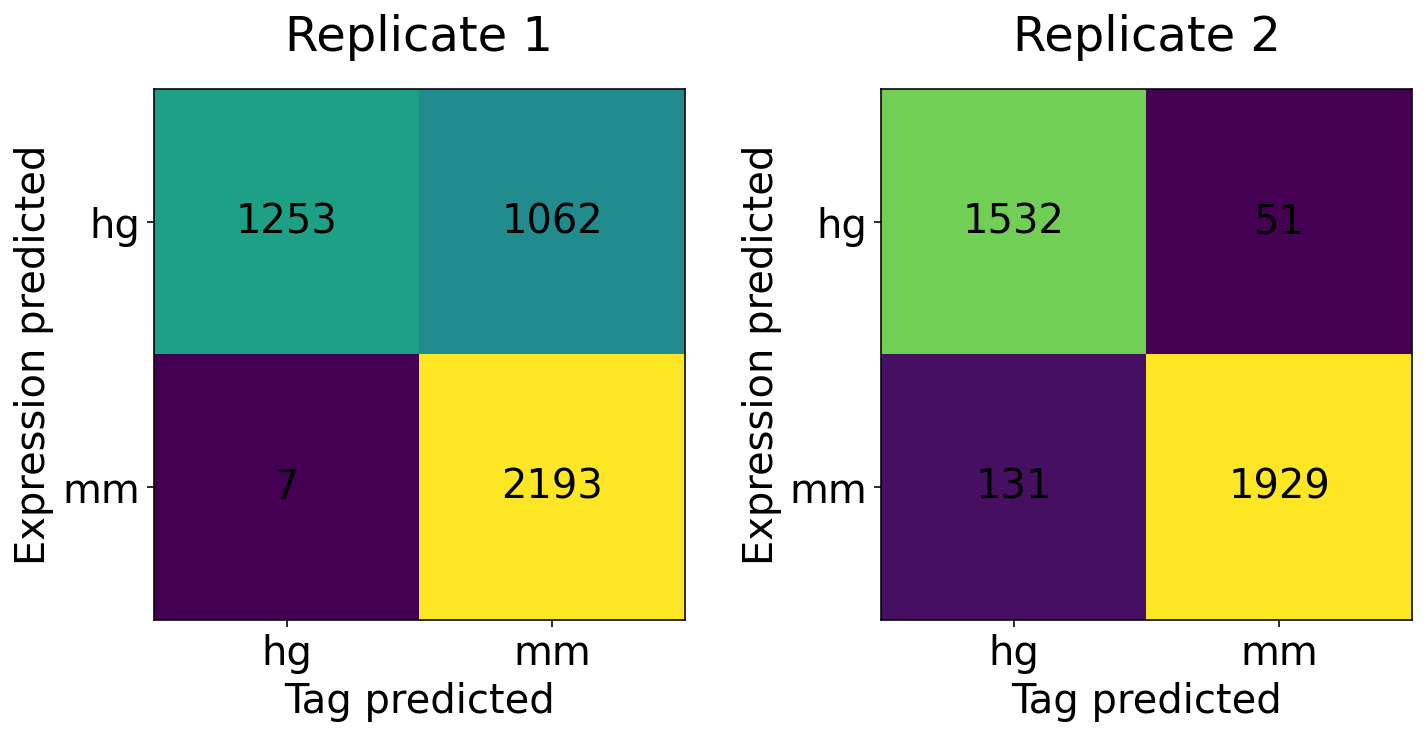

In [136]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, constrained_layout=True)


ax = axs[0]
x = cfm1

ax.matshow(x)
for (i, j), z in np.ndenumerate(x):
    ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')

ax.set(**{
    "title": "Replicate 1",
    "xticks": [0,1],
    "xticklabels": ["hg", "mm"],
    "yticks": [0,1],
    "yticklabels": ["hg", "mm"],
    "xlabel": "Tag predicted",
    "ylabel": "Expression predicted"
})
ax.xaxis.set_ticks_position('bottom')

ax = axs[1]
x = cfm2

ax.matshow(x)
for (i, j), z in np.ndenumerate(x):
    ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')

ax.set(**{
    "title": "Replicate 2",
    "xticks": [0,1],
    "xticklabels": ["hg", "mm"],
    "yticks": [0,1],
    "yticklabels": ["hg", "mm"],
    "xlabel": "Tag predicted",
    "ylabel": "Expression predicted"
})
ax.xaxis.set_ticks_position('bottom')


fig.show()

In [113]:
nd(r2[:,r2.var.index.str.contains("_ENSG")].X.sum(1)), nd(r2[:,r2.var.index.str.contains("_ENSMUS")].X.sum(1))

(array([   59.,  9975.,  1993., ..., 12319.,    48.,  1967.], dtype=float32),
 array([560., 409., 347., ..., 473., 787., 192.], dtype=float32))